In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("C:/msys64/home/for/10th/standard/LinearBNB/2025_Airbnb_NYC_listings.csv")

In [51]:
# 필요한 전체 컬럼 선정
df = df[['calculated_host_listings_count', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
         'host_identity_verified', 'neighbourhood_cleansed',
         'neighbourhood_group_cleansed', 'latitude','longitude', 'room_type', 'accommodates', 'bedrooms', 
         'beds', 'bathrooms', 'amenities', 'price', 
         'minimum_nights', 'maximum_nights', 'availability_365', 
         'number_of_reviews', 'reviews_per_month', 'review_scores_rating', 
         'review_scores_cleanliness', 'review_scores_communication', 'last_review']].copy()

In [52]:
# 데이터 변환

## 가격 컬럼($ , 표시 제거 및 실수화)
df['price'] = pd.to_numeric(df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False), errors='coerce')

## 호스트 응답률 컬럼(% 제거 및 실수화)
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.replace('%', '', regex=False), errors='coerce')

## 호스트 예약 응답률 컬럼(% 제거 및 실수화)
df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'].str.replace('%', '', regex=False), errors='coerce')

## 마지막 리뷰 일자 컬럼(datetime 타입 변환)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

## 컬럼 이름 변경
df = df.rename(columns={
    'host_response_rate' : 'host_response_rate(%)',
    'host_acceptance_rate' : 'host_acceptance_rate(%)',
    'price' : 'price($)'})


In [53]:
# 파생변수 생성

## amenities_count
def count_amenities(x):
    if isinstance(x, str):
        clean_x = x.replace('[', '').replace(']', '').replace('"', '').replace("'", "")
        if clean_x == "": return 0
        return len(clean_x.split(','))
    elif isinstance(x, list):
        return len(x)
    return 0

df['amenities_count'] = df['amenities'].apply(count_amenities)

## days_since_last_review(데이터 수집일자를 기준으로 며칠이 지났는지)
base_date = pd.to_datetime('2025-03-02')
df['days_since_last_review'] = (base_date - df['last_review']).dt.days

## dist_from_center(타임스퀘어로부터 숙소의 거리, 하버사인 공식)
from haversine import haversine

center = (40.7580, -73.9855)
df['dist_from_center(km)'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), center, unit='km'), axis=1)

## estimated_occupancy(추정 가동률)
df['estimated_occupancy'] = (df['reviews_per_month'] * df['minimum_nights']) / 30
df['estimated_occupancy'] = df['estimated_occupancy'].clip(upper=1)

## minimum_nights_cleansed(30일 미만은 그대로, 30일이상은 30일로)
df['minimum_nights_cleansed'] = df['minimum_nights'].clip(lower=1, upper=30)

# 컬럼 재정렬
df = df[['calculated_host_listings_count', 'host_response_time', 'host_response_rate(%)', 'host_acceptance_rate(%)', 'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
         'neighbourhood_group_cleansed', 'latitude','longitude', 'dist_from_center(km)', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'price($)', 
         'minimum_nights_cleansed', 'maximum_nights', 'availability_365', 'number_of_reviews', 'reviews_per_month', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication', 'last_review', 'days_since_last_review', 'estimated_occupancy']].copy()

In [54]:
df['minimum_nights_cleansed']

0        30
1        30
2         3
3         2
4         4
         ..
22303    30
22304    30
22305    30
22306    30
22307    30
Name: minimum_nights_cleansed, Length: 22308, dtype: int64

In [55]:
###
df['days_since_last_review']

0       4314.000000
1        449.000000
2        550.000000
3          9.000000
4         58.000000
            ...    
22303           NaN
22304           NaN
22305           NaN
22306           NaN
22307           NaN
Name: days_since_last_review, Length: 22308, dtype: float64

데이터 기준일 : 2025-03-02
[리뷰 경과일 분위수 분석]
상위 50% 커버 범위: 157일 이내 (~2024-09-26)
상위 75% 커버 범위: 515일 이내 (~2023-10-04)
상위 80% 커버 범위: 548일 이내 (~2023-09-01)
상위 90% 커버 범위: 853일 이내 (~2022-10-31)
상위 95% 커버 범위: 1437일 이내 (~2021-03-25)
상위 99% 커버 범위: 2517일 이내 (~2018-04-10)


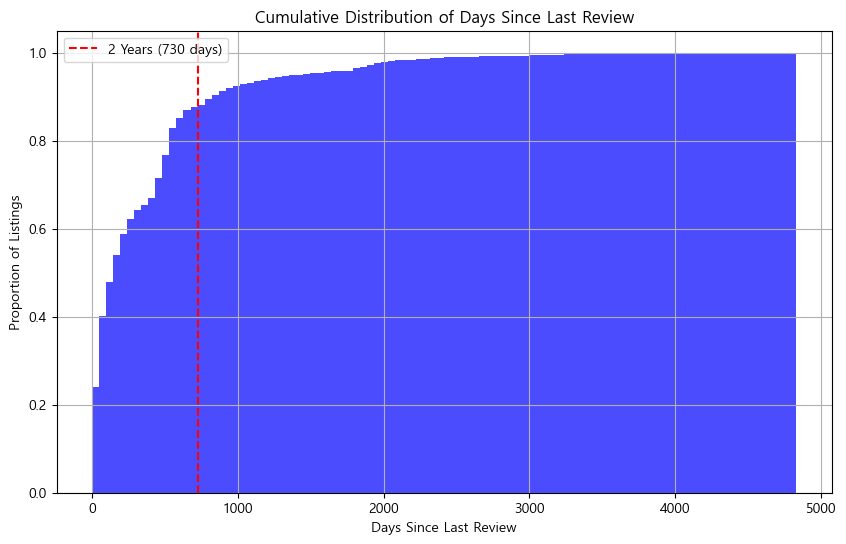

In [56]:
df_reviews = df[df['last_review'].notnull()].copy()

ref_date = df_reviews['last_review'].max()
print(f"데이터 기준일 : {ref_date.date()}")

df_reviews['days_since_last_review'] = (ref_date - df_reviews['last_review']).dt.days

quantiles = [0.5, 0.75, 0.8, 0.9, 0.95, 0.99]
q_values = df_reviews['days_since_last_review'].quantile(quantiles)

print("[리뷰 경과일 분위수 분석]")
for q, days in q_values.items():
    cutoff_date = ref_date - pd.Timedelta(days=days)
    print(f"상위 {int(q*100)}% 커버 범위: {days:.0f}일 이내 (~{cutoff_date.date()})")

# 누적 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(df_reviews['days_since_last_review'], bins=100, cumulative=True, density=True, alpha=0.7, color='blue')
plt.axvline(x=730, color='red', linestyle='--', label='2 Years (730 days)') # 우리가 정했던 2년 기준선
plt.title('Cumulative Distribution of Days Since Last Review')
plt.xlabel('Days Since Last Review')
plt.ylabel('Proportion of Listings')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# 데이터 필터링

## 리뷰가 0개인 숙소 제외
df = df[df['number_of_reviews'] != 0].copy()

## 마지막 리뷰가 2년을 초과하는 숙소 제외
df = df[df['last_review'] >= '2023-03-02'].copy()

## 가격이 $0인 숙소 제외
df = df[df['price($)'] != 0].copy().reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13599 entries, 0 to 13598
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   calculated_host_listings_count  13599 non-null  int64         
 1   host_response_time              11488 non-null  object        
 2   host_response_rate(%)           11488 non-null  float64       
 3   host_acceptance_rate(%)         12308 non-null  float64       
 4   host_is_superhost               13325 non-null  object        
 5   host_identity_verified          13584 non-null  object        
 6   neighbourhood_cleansed          13599 non-null  object        
 7   neighbourhood_group_cleansed    13599 non-null  object        
 8   latitude                        13599 non-null  float64       
 9   longitude                       13599 non-null  float64       
 10  dist_from_center(km)            13599 non-null  float64       
 11  ro

In [58]:
# 결측치 확인

## 침실, 침대, 화장실 수, 호스트 응답 시간, 응답률, 예약 요청 수락률, 슈퍼 호스트, 신원 인증 여부 결측치 확인
df[df['beds'].isnull() | df['bedrooms'].isnull() | df['bathrooms'].isnull() | df['host_response_time'].isnull() | df['host_response_rate(%)'].isnull() | df['host_acceptance_rate(%)'].isnull() | df['host_is_superhost'].isnull() | df['host_identity_verified'].isnull()].copy()

,calculated_host_listings_count,host_response_time,host_response_rate(%),host_acceptance_rate(%),host_is_superhost,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,...,maximum_nights,availability_365,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,last_review,days_since_last_review,estimated_occupancy
0,1,NaN,NaN,100.000000,f,t,East Harlem,Manhattan,40.792454,-73.940742,...,999,204,102,0.580000,4.770000,4.760000,4.900000,2023-12-09,449.000000,0.580000
8,2,within an hour,100.000000,NaN,f,t,Bedford-Stuyvesant,Brooklyn,40.684556,-73.939634,...,1125,150,190,1.010000,4.770000,4.740000,4.880000,2023-10-16,503.000000,1.000000
9,2,within an hour,100.000000,NaN,f,t,Bedford-Stuyvesant,Brooklyn,40.684569,-73.938400,...,730,144,173,1.030000,4.720000,4.730000,4.890000,2023-11-01,487.000000,1.000000
12,1,NaN,NaN,100.000000,f,t,Lower East Side,Manhattan,40.719920,-73.991670,...,240,145,70,0.390000,4.800000,4.690000,4.870000,2024-08-31,183.000000,0.390000
22,1,NaN,NaN,NaN,f,t,Fort Greene,Brooklyn,40.693047,-73.971985,...,31,60,285,1.690000,4.720000,4.750000,4.770000,2023-09-04,545.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,1,NaN,NaN,100.000000,NaN,t,Bedford-Stuyvesant,Brooklyn,40.695291,-73.946560,...,180,169,1,0.320000,5.000000,5.000000,5.000000,2024-11-30,92.000000,0.320000
13398,138,within a few hours,98.000000,72.000000,t,t,Upper East Side,Manhattan,40.772758,-73.951110,...,365,349,2,1.200000,5.000000,5.000000,5.000000,2025-02-11,19.000000,1.000000
13445,68,within an hour,100.000000,100.000000,f,t,Midtown,Manhattan,40.746444,-73.988726,...,365,293,3,0.970000,5.000000,5.000000,3.670000,2025-02-23,7.000000,0.032333
13468,10,within a few hours,99.000000,8.000000,NaN,t,East Village,Manhattan,40.722385,-73.986581,...,365,275,1,1.000000,5.000000,5.000000,5.000000,2025-02-15,15.000000,1.000000


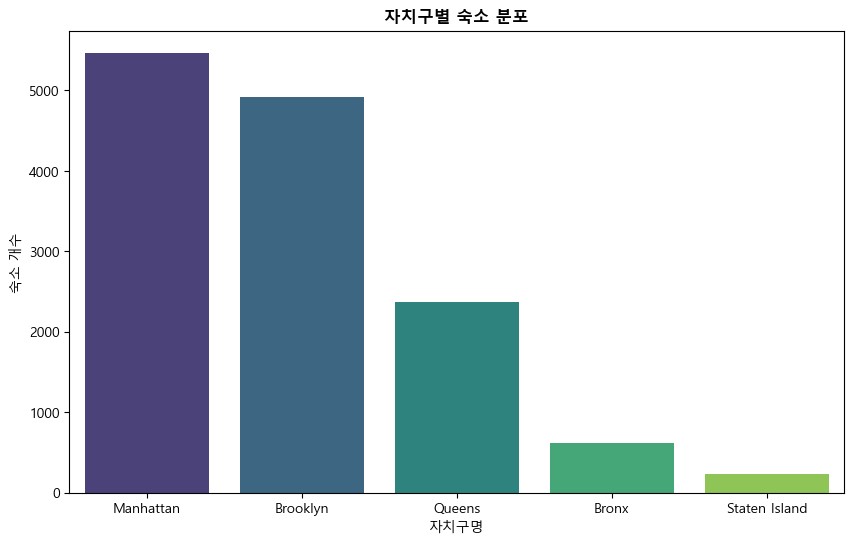

In [59]:
# 시장 분석(자치구별 숙소 개수)

import warnings

warnings.filterwarnings("ignore")
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))

sns.countplot(
    data=df, 
    x='neighbourhood_group_cleansed', 
    order=df['neighbourhood_group_cleansed'].value_counts().index, 
    palette='viridis'
)

plt.title('자치구별 숙소 분포', fontweight='bold')
plt.xlabel('자치구명')
plt.ylabel('숙소 개수')
plt.show()

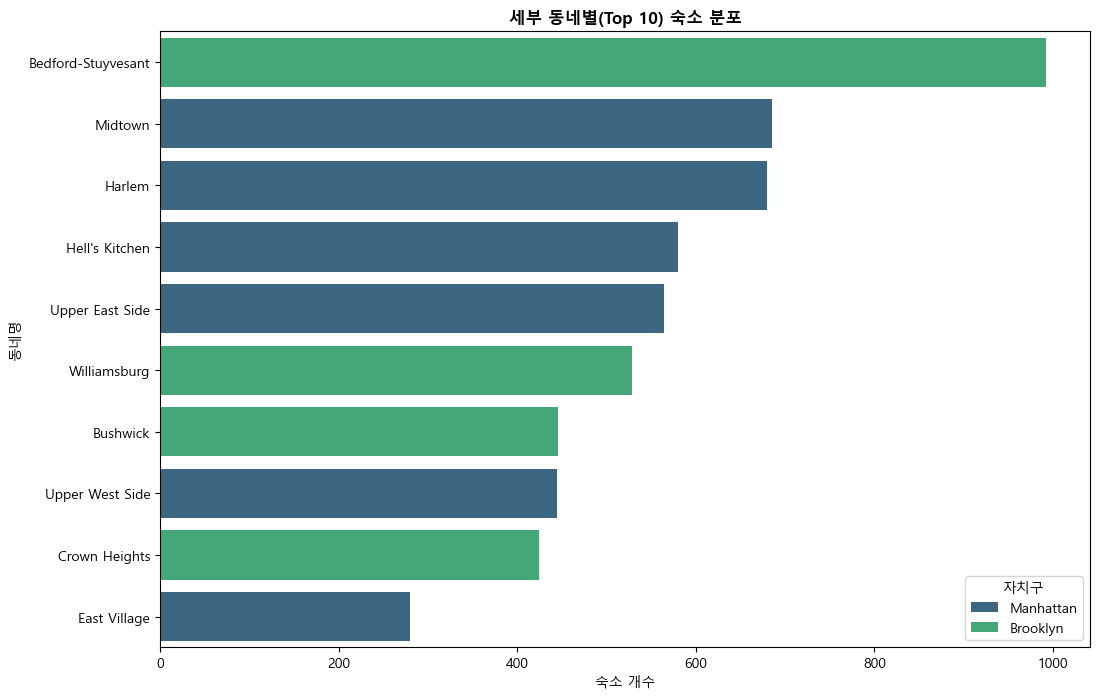

In [60]:
# 가장 핫한 동네 Top 10

top_10_names = df['neighbourhood_cleansed'].value_counts().head(10).index

df_top10 = df[df['neighbourhood_cleansed'].isin(top_10_names)]

plt.figure(figsize=(12, 8))

sns.countplot(
    data=df_top10, 
    y='neighbourhood_cleansed', 
    order=top_10_names,
    hue='neighbourhood_group_cleansed',
    palette='viridis',
    dodge=False
)

plt.title('세부 동네별(Top 10) 숙소 분포', fontweight='bold')
plt.xlabel('숙소 개수')
plt.ylabel('동네명')

plt.legend(title='자치구', loc='lower right')

plt.show()

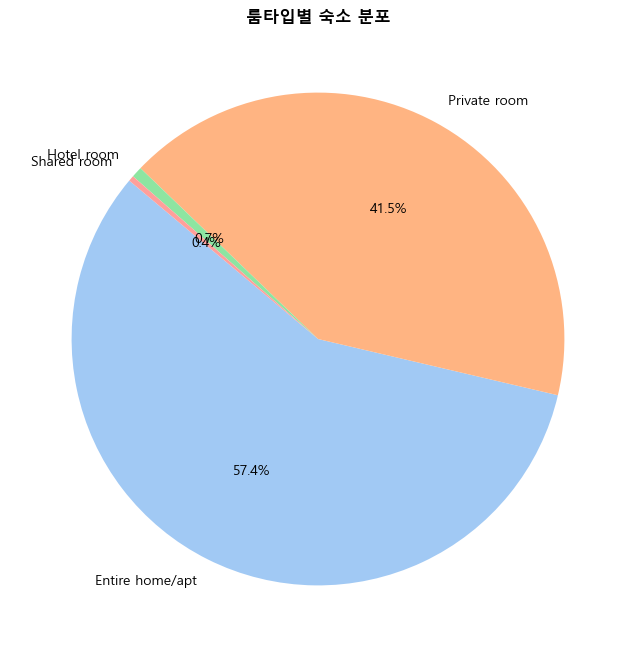

In [61]:
# 룸타입별 개수 계산
room_counts = df['room_type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    room_counts, 
    labels=room_counts.index, 
    autopct='%1.1f%%',
    startangle=140, 
    colors=sns.color_palette('pastel')
)

plt.title('룸타입별 숙소 분포', fontweight='bold')
plt.show()

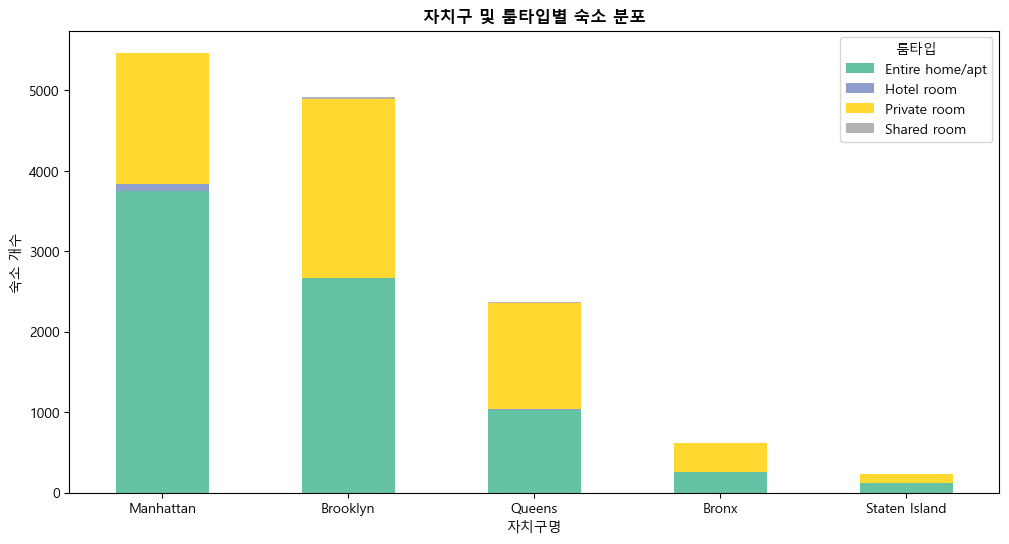

In [62]:
ct = pd.crosstab(df['neighbourhood_group_cleansed'], df['room_type'])

ct = ct.loc[df['neighbourhood_group_cleansed'].value_counts().index]

ct.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title('자치구 및 룸타입별 숙소 분포', fontweight='bold')
plt.xlabel('자치구명')
plt.ylabel('숙소 개수')
plt.legend(title='룸타입')
plt.xticks(rotation=0) 
plt.show()

# 가격 선정 전략

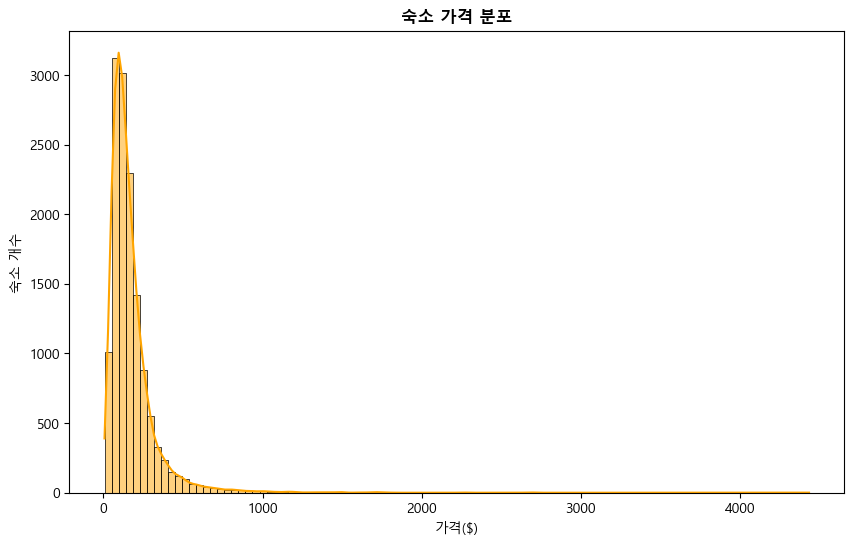

In [63]:
# 숙소 가격 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['price($)'], bins=100, kde=True, color='orange')
plt.title('숙소 가격 분포', fontweight='bold')
plt.xlabel('가격($)')
plt.ylabel('숙소 개수')
plt.show()

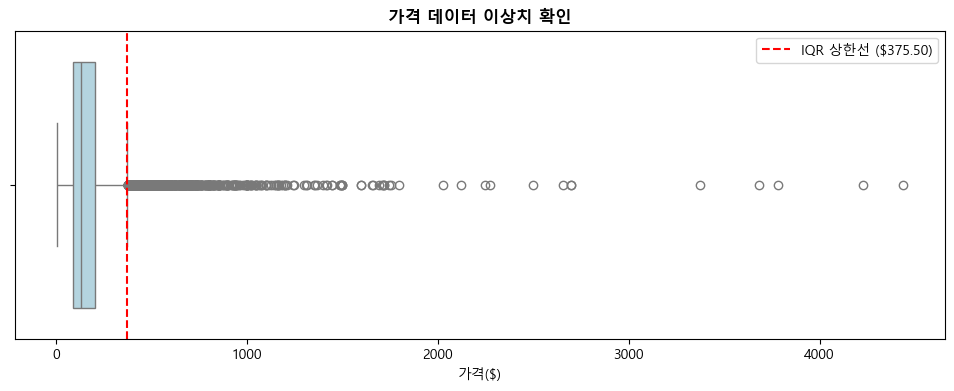

In [64]:
# 이상치 처리(IQR)

Q1 = df['price($)'].quantile(0.25)
Q3 = df['price($)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(12, 4))
sns.boxplot(x=df['price($)'], color='lightblue')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'IQR 상한선 (${upper_bound:.2f})')
plt.title('가격 데이터 이상치 확인', fontweight='bold')
plt.legend()
plt.xlabel('가격($)')
plt.show()

In [65]:
# 초저가 / 초고가 숙소 개수
cheap_list = df[df['price($)'] < 30].copy()
expansive_list = df[df['price($)'] > 1000].copy()

print(f"$30 미만 숙소 개수: {len(cheap_list)}개")
print(f"$1000 초과 숙소 개수 : {len(expansive_list)}개")

cheap_list.to_csv('cheap.csv', encoding='utf-8', index=False)
expansive_list.to_csv('expansive.csv', encoding='utf-8', index=False)

$30 미만 숙소 개수: 17개
$1000 초과 숙소 개수 : 75개


In [66]:
from scipy import stats

# 상관관계 분석(연속형 변수 vs 가격)

pd.options.display.float_format = '{:.6f}'.format

numeric_columns = [
    'calculated_host_listings_count',
    'host_response_rate(%)',
    'host_acceptance_rate(%)',
    'latitude',
    'longitude',
    'dist_from_center(km)',
    'accommodates',
    'bedrooms',
    'beds',
    'bathrooms',
    'amenities_count',
    'minimum_nights_cleansed',
    'maximum_nights',
    'availability_365',
    'number_of_reviews',
    'reviews_per_month',
    'review_scores_rating',
    'review_scores_cleanliness',
    'review_scores_communication',
    'days_since_last_review',
    'estimated_occupancy'
]

target = 'price($)'
results = []

for col in numeric_columns:
    temp_df = df[[col, target]].dropna()
    
    if len(temp_df) < 10: 
        continue
        
    corr, p_val = stats.spearmanr(temp_df[col], temp_df[target])
    
    results.append({
        'Feature': col,
        'Correlation': corr,     
        'P-value': p_val
    })

result_df = pd.DataFrame(results)
    
display(result_df[['Feature', 'Correlation', 'P-value']])

,Feature,Correlation,P-value
0,calculated_host_listings_count,-0.099603,0.000000
1,host_response_rate(%),0.038529,0.000036
2,host_acceptance_rate(%),0.073359,0.000000
3,latitude,0.030999,0.000300
4,longitude,-0.323031,0.000000
5,dist_from_center(km),-0.342457,0.000000
6,accommodates,0.576867,0.000000
7,bedrooms,0.345848,0.000000
8,beds,0.450931,0.000000
9,bathrooms,0.162294,0.000000


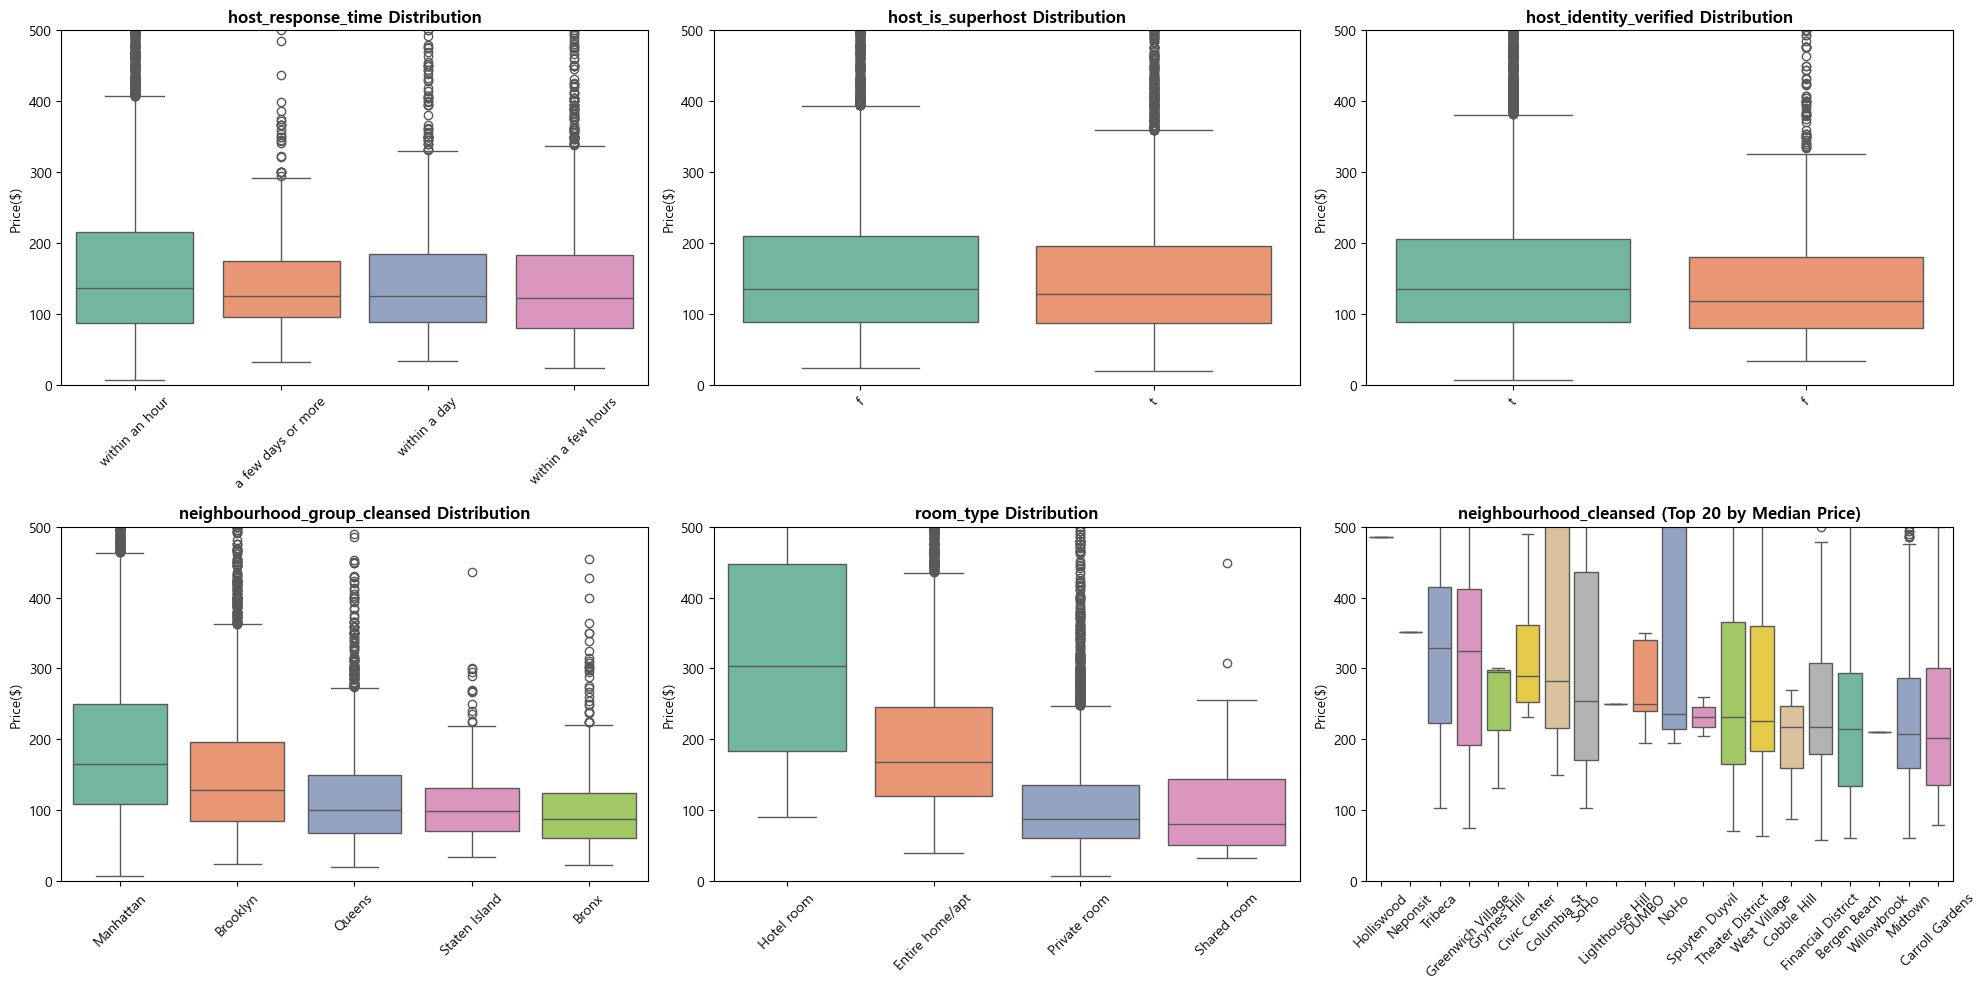

In [67]:
# 범주형 변수 vs 가격 (시각화)

import math

categorical_columns = [
    'host_response_time', 
    'host_is_superhost', 
    'host_identity_verified',
    'neighbourhood_group_cleansed', 
    'room_type',
    'neighbourhood_cleansed'
]

n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

plt.figure(figsize=(20, 5 * n_rows))

for i, col in enumerate(categorical_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    plot_data = df[[col, 'price($)']].dropna()
    
    ## 카테고리가 너무 많은 동네 컬럼의 경우 상위 20개만 추출
    if plot_data[col].nunique() > 20:
        top_20 = plot_data.groupby(col)['price($)'].median().sort_values(ascending=False).head(20).index
        plot_data = plot_data[plot_data[col].isin(top_20)]
        title_text = f'{col} (Top 20 by Median Price)'
    else:
        title_text = f'{col} Distribution'
        
    order = plot_data.groupby(col)['price($)'].median().sort_values(ascending=False).index
    
    sns.boxplot(x=col, y='price($)', data=plot_data, order=order, palette='Set2')

    plt.ylim(0, 500)
    plt.title(title_text, fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Price($)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [68]:
# 가설 검증(Kruskal-Wallis H Test + Eta Squared)

categorical_columns = [
    'host_response_time', 
    'host_is_superhost', 
    'host_identity_verified',
    'neighbourhood_group_cleansed', 
    'room_type',
    'neighbourhood_cleansed'
]

results = []

for col in categorical_columns:
    clean_df = df[[col, 'price($)']].dropna()
    
    # 그룹별로 가격 데이터 수집 (예: Manhattan 그룹 가격, Brooklyn 그룹 가격...)
    groups = []
    for category in clean_df[col].unique():
        groups.append(clean_df[clean_df[col] == category]['price($)'])
    
    if len(groups) < 2:
        continue

    ## Kruskal-Wallis H Test 수행
    ## H: 통계량, p_value: 유의확률
    H, p_value = stats.kruskal(*groups)
    
    ## Eta Squared(효과 크기) 계산
    # 공식: (H - k + 1) / (n - k) / 자유도 보정 공식
    k = len(groups)       # 컬럼별 범주의 수
    n = len(clean_df)     # 전체 데이터 수
    
    if n - k <= 0: # 분모가 0이 되는 예외 상황 방지
        eta_squared = 0
    else:
        eta_squared = (H - k + 1) / (n - k)

    results.append({
        'Feature': col,
        'H-Statistic': H,
        'P-value': p_value,
        'Epsilon_Squared' : eta_squared
    })

results_df = pd.DataFrame(results).sort_values(by='Epsilon_Squared', ascending=False)
display(results_df)

,Feature,H-Statistic,P-value,Epsilon_Squared
4,room_type,3472.740150,0.000000,0.255222
5,neighbourhood_cleansed,3139.929451,0.000000,0.218497
3,neighbourhood_group_cleansed,1365.756946,0.000000,0.100173
0,host_response_time,53.974889,0.000000,0.004439
2,host_identity_verified,42.467938,0.000000,0.003053
1,host_is_superhost,12.367524,0.000437,0.000853


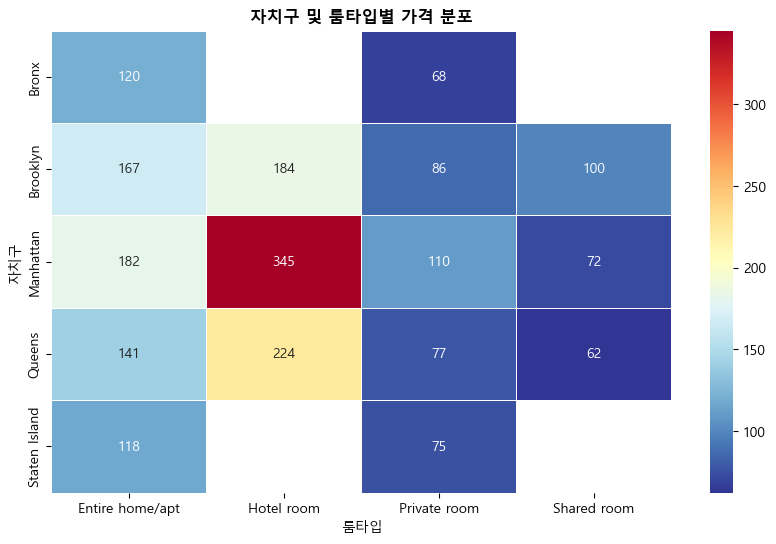

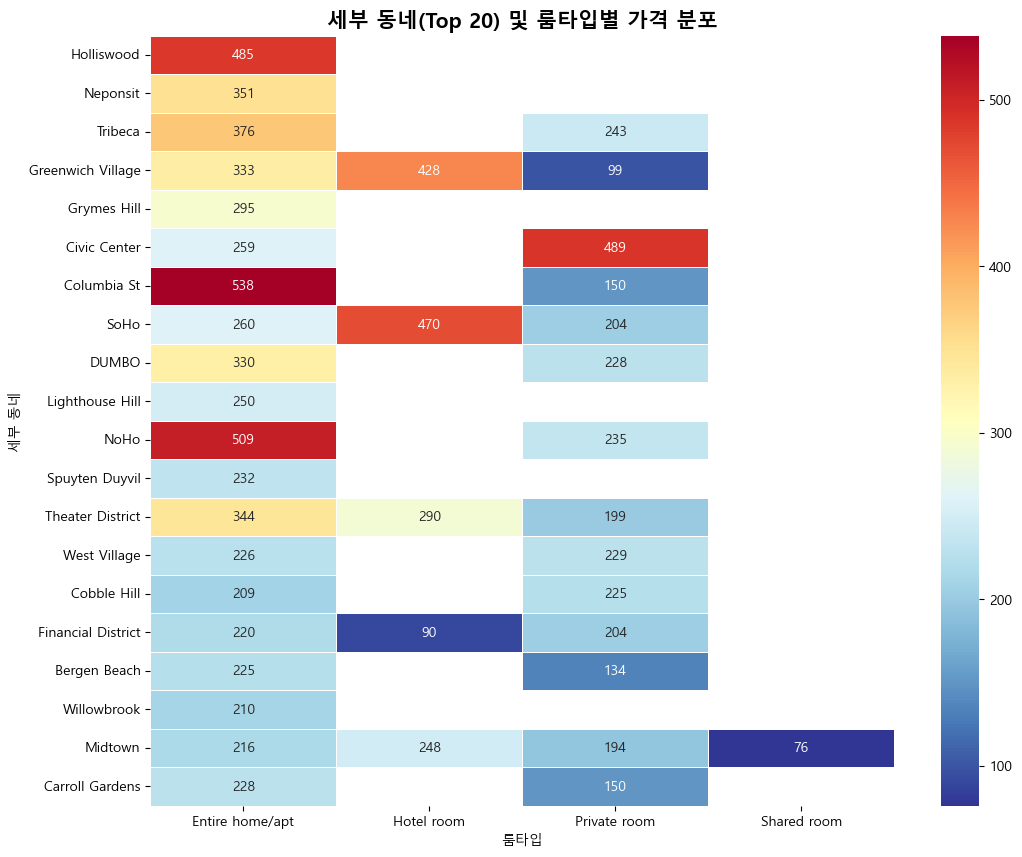

In [69]:
# 선정된 변수의 교차 분석 및 상호작용 확인

## 자치구 & 룸타임별 가격 분포
pivot_price = df.pivot_table(
    index='neighbourhood_group_cleansed', 
    columns='room_type', 
    values='price($)', 
    aggfunc='median'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_price, annot=True, fmt='.0f', cmap='RdYlBu_r', linewidths=.5)
plt.title('자치구 및 룸타입별 가격 분포', fontweight='bold')
plt.xlabel('룸타입')
plt.ylabel('자치구')
plt.show()

## 세부 동네(Top 20) & 룸타임별 가격 분포
top_20_neighborhoods = df.groupby('neighbourhood_cleansed')['price($)'].median().sort_values(ascending=False).head(20).index

df_top20 = df[df['neighbourhood_cleansed'].isin(top_20_neighborhoods)]


pivot_neighborhood = df_top20.pivot_table(
    index='neighbourhood_cleansed', 
    columns='room_type', 
    values='price($)', 
    aggfunc='median'
)

pivot_neighborhood = pivot_neighborhood.reindex(top_20_neighborhoods)

plt.figure(figsize=(12, 10)) # 세로를 좀 길게 잡음
sns.heatmap(pivot_neighborhood, annot=True, fmt='.0f', cmap='RdYlBu_r', linewidths=.5)

plt.title('세부 동네(Top 20) 및 룸타입별 가격 분포', fontsize=15, fontweight='bold')
plt.xlabel('룸타입')
plt.ylabel('세부 동네')
plt.show()

In [70]:
# 모델링에 사용할 컬럼 선정
df_modeling = df[['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'latitude', 'longitude', 'dist_from_center(km)', 'room_type', 'price($)', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'minimum_nights_cleansed', 'estimated_occupancy']].copy()

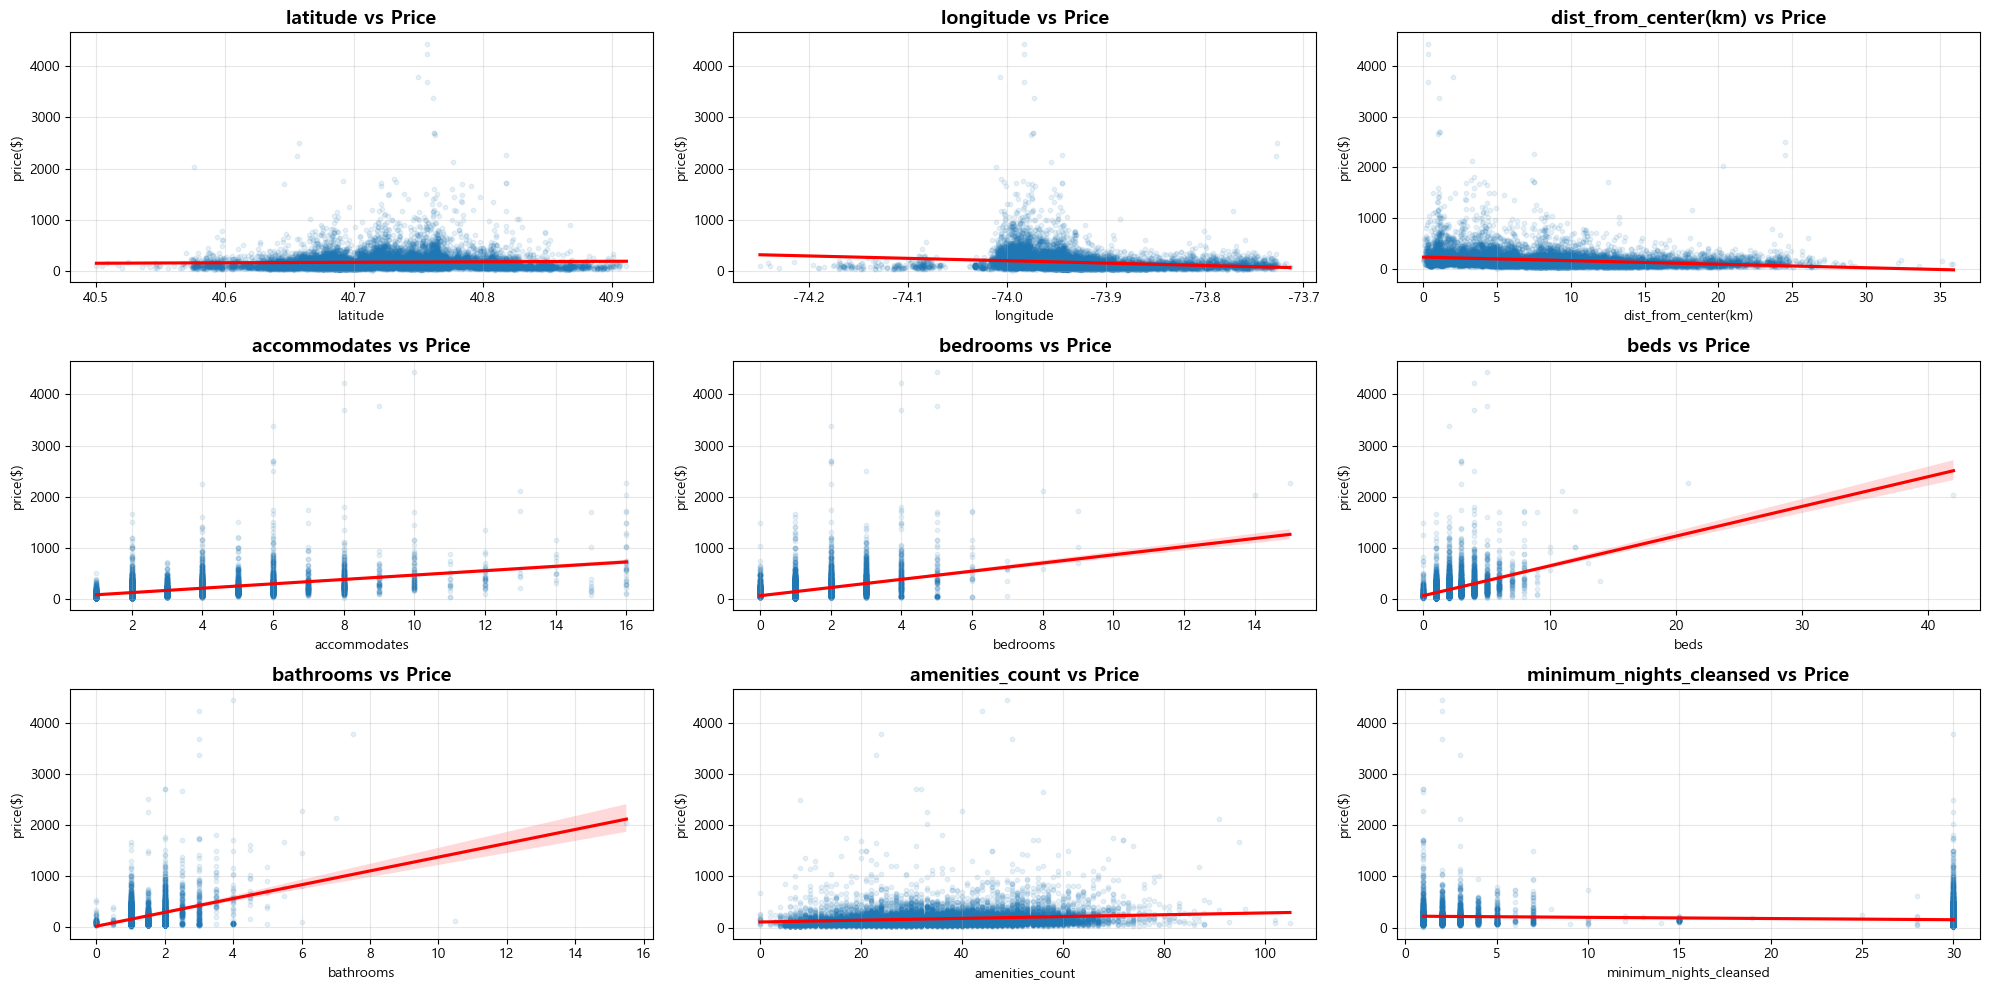

In [71]:
# 연속형 변수와 종속변수 간의 선형 / 비선형 관계 확인
numeric_columns = [
    'latitude',
    'longitude',
    'dist_from_center(km)',     
    'accommodates',    
    'bedrooms',         
    'beds',
    'bathrooms',    
    'amenities_count', 
    'minimum_nights_cleansed'    
]
target = 'price($)'

plt.figure(figsize=(20, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(x=col, y=target, data=df_modeling, 
                scatter_kws={'alpha':0.1, 's':10, 'color':'#1f77b4'}, 
                line_kws={'color':'red'})
    
    plt.title(f'{col} vs Price', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# 모델링을 위한 전처리

## bedrooms & beds 기준 결측치 제거
df_modeling = df_modeling[df_modeling['bedrooms'].notna() & df_modeling['beds'].notna() & df_modeling['bathrooms'].notna()].copy()

## 데이터 2차 필터링
df_modeling = df_modeling[df_modeling['estimated_occupancy'] > 0.1].copy().reset_index(drop=True)

# 선형회귀 모델링

In [73]:
# 모델링 부적합 변수 및 불필요 변수 제거
df_modeling_lr = df_modeling[['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'dist_from_center(km)', 'room_type', 'price($)', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'minimum_nights_cleansed']].copy()
df_modeling_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11154 entries, 0 to 11153
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  11154 non-null  object 
 1   neighbourhood_cleansed        11154 non-null  object 
 2   dist_from_center(km)          11154 non-null  float64
 3   room_type                     11154 non-null  object 
 4   price($)                      11154 non-null  float64
 5   accommodates                  11154 non-null  int64  
 6   bedrooms                      11154 non-null  float64
 7   beds                          11154 non-null  float64
 8   bathrooms                     11154 non-null  float64
 9   amenities_count               11154 non-null  int64  
 10  minimum_nights_cleansed       11154 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 958.7+ KB


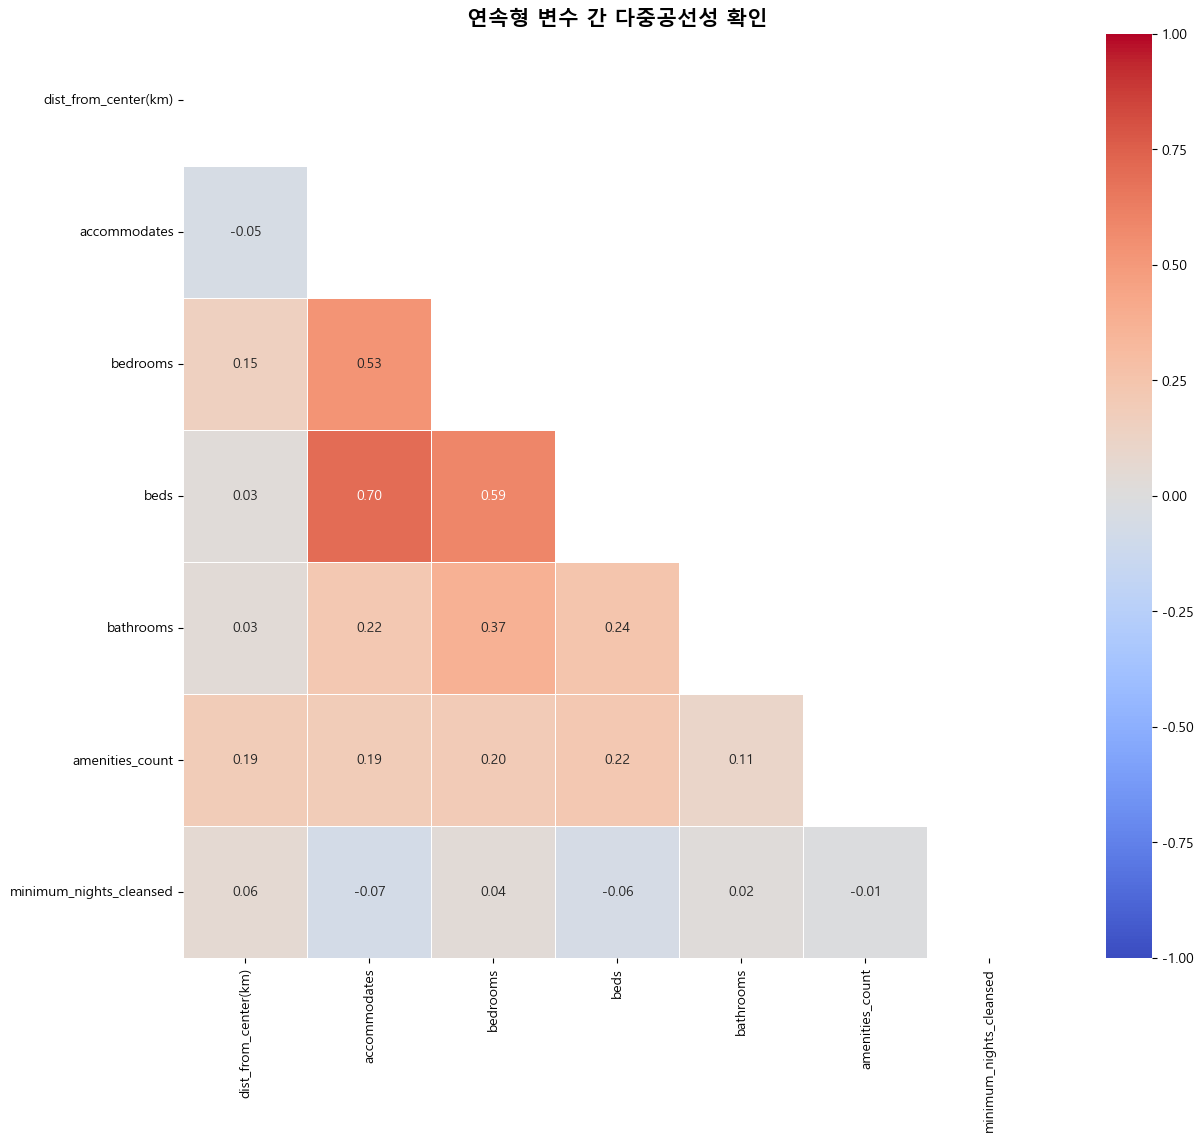

In [74]:
# 선택된 연속형 변수 간 다중공선성 확인(스피어만 상관관계 히트맵 시각화)
selected_columns = [
    'dist_from_center(km)',
    'accommodates', 
    'bedrooms', 
    'beds',
    'bathrooms',
    'amenities_count',
    'minimum_nights_cleansed' 
]

corr_matrix = df[selected_columns].corr(method='spearman')

plt.figure(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    center=0,
    mask=mask,
    linewidths=0.5
)

plt.title('연속형 변수 간 다중공선성 확인', fontsize=15, fontweight='bold')
plt.show()

In [75]:
# 연속형 변수 간 다중공선성 확인(VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

selected_columns = [
    'dist_from_center(km)',
    'accommodates', 
    'bedrooms', 
    'beds',
    'bathrooms',
    'amenities_count',
    'minimum_nights_cleansed'
]

X_vif = df[selected_columns].dropna()

X_vif_with_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_with_const.values, i) for i in range(len(X_vif_with_const.columns))]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
display(vif_data[vif_data['feature'] != 'const'])

,feature,VIF
4,beds,2.776966
2,accommodates,2.586036
3,bedrooms,2.301789
5,bathrooms,1.346232
6,amenities_count,1.079336
1,dist_from_center(km),1.062380
7,minimum_nights_cleansed,1.016917


In [76]:
# 범주형 변수 간 다중공선성 확인(Cramer's V)

from scipy.stats import chi2_contingency

cat_cols = ['neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'room_type']
df_cat = df_modeling_lr[cat_cols]

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

rows = []
for var1 in cat_cols:
    col = []
    for var2 in cat_cols:
        col.append(cramers_v(df_cat[var1], df_cat[var2]))
    rows.append(col)

cramers_v_matrix = pd.DataFrame(rows, columns=cat_cols, index=cat_cols)
display(cramers_v_matrix)

,neighbourhood_group_cleansed,neighbourhood_cleansed,room_type
neighbourhood_group_cleansed,1.000000,0.990718,0.132457
neighbourhood_cleansed,0.990718,1.000000,0.193257
room_type,0.132457,0.193257,1.000000


In [77]:
# 선형회귀 모델링을 위한 변수
df_modeling_lr = df_modeling_lr[['neighbourhood_group_cleansed', 'dist_from_center(km)', 'room_type', 'price($)', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'minimum_nights_cleansed']].copy()

In [78]:
# 로그변환
df_modeling_lr['log_price'] = np.log1p(df_modeling_lr['price($)'])

In [79]:
# 범주형 변수 인코딩
cat_cols = ['neighbourhood_group_cleansed', 'room_type']

df_modeling_lr_final = df_final = pd.get_dummies(df_modeling_lr, columns=cat_cols, drop_first=True)

In [80]:
# 선형회귀 모델링

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 독립변수(X)와 종속변수(y) 설정
X = df_modeling_lr_final.drop(['price($)', 'log_price'], axis=1) 
y = df_modeling_lr_final['log_price']

# 학습 데이터와 테스트 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- 선형 회귀 모델 결과 ---")
print(f"R² Score (결정계수): {r2:.4f}")
print(f"RMSE (로그 단위 오차): {rmse:.4f}")

--- 선형 회귀 모델 결과 ---
R² Score (결정계수): 0.5722
RMSE (로그 단위 오차): 0.4180


In [81]:
# 과적합 체크
print(f"Train R2: {lr_model.score(X_train, y_train):.4f}")
print(f"Test R2: {lr_model.score(X_test, y_test):.4f}")


Train R2: 0.5636
Test R2: 0.5722


In [82]:
# 통계적 유의성 검정 (P-value 확인)
import statsmodels.api as sm

# statsmodels를 위해 상수항(intercept) 추가
X_train_sm = sm.add_constant(X_train).astype(float)

# OLS(최소자승법) 모델 생성 및 학습
sm_model = sm.OLS(y_train, X_train_sm).fit()

# 전체 요약 리포트 출력
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     821.7
Date:                Mon, 29 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:58:39   Log-Likelihood:                -4904.2
No. Observations:                8923   AIC:                             9838.
Df Residuals:                    8908   BIC:                             9945.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

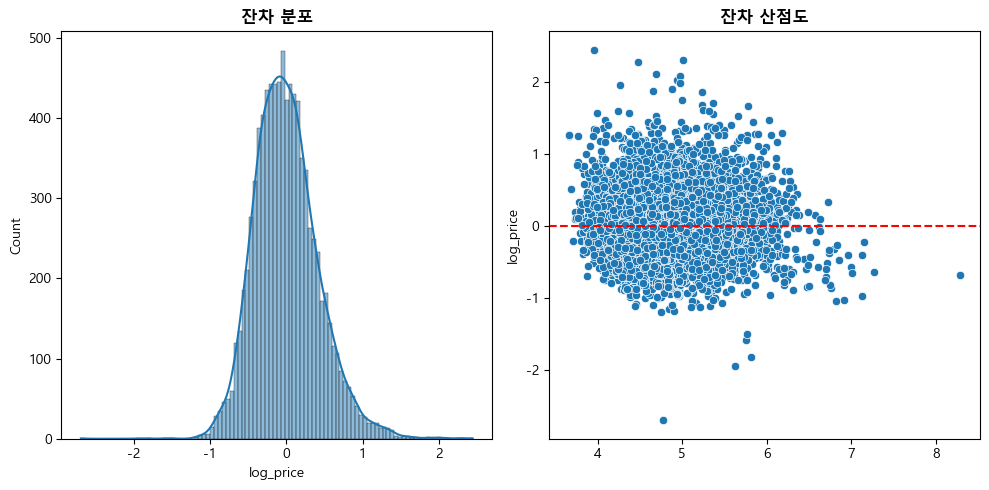

In [83]:
# 잔차 
from sklearn.metrics import mean_absolute_percentage_error

y_train_pred = lr_model.predict(X_train)
residuals = y_train - y_train_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('잔차 분포', fontweight='bold')
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('잔차 산점도', fontweight='bold')
plt.tight_layout()
plt.show()


In [84]:
# 평균 절대 백분율 오차
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(lr_model.predict(X_test)) 
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

print(f"\n평균 오차율(MAPE): {mape * 100:.2f}%")


평균 오차율(MAPE): 33.73%


# 앙상블 모델을 위한 전처리

In [85]:
df_modeling_en = df_modeling.copy()


# 로그 변환
df_modeling_en['log_price'] = np.log1p(df_modeling_en['price($)'])

# 범주형 변수 인코딩
from sklearn.preprocessing import LabelEncoder

## 원-핫 인코딩(자치구, 룸타입)
df_modeling_en = pd.get_dummies(df_modeling_en, columns=['neighbourhood_group_cleansed', 'room_type'], prefix=['dist', 'room'])

## 라벨 인코딩(세부 동네)
le = LabelEncoder()
df_modeling_en['neighbourhood_encoded'] = le.fit_transform(df_modeling_en['neighbourhood_cleansed'])

# 모델링에 필요한 최종 컬럼
df_modeling_en_final = df_modeling_en[['latitude', 'longitude', 'dist_from_center(km)', 'price($)', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'minimum_nights_cleansed', 'log_price', 'dist_Bronx', 'dist_Brooklyn', 
'dist_Manhattan', 'dist_Queens', 'dist_Staten Island', 'room_Entire home/apt', 'room_Hotel room', 'room_Private room', 'room_Shared room', 'neighbourhood_encoded']]



# Random Forest

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# X, y 분리
X = df_modeling_en_final.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_en_final['log_price']

# Train과 Test 셋 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, max_depth=11, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 예측 수행
y_pred_log = rf_model.predict(X_test)

# 기본 성능
r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score (결정계수) : {r2_log:.4f}")
print(f"RMSE (평균제곱근오차): {rmse_log:.4f}")

R² Score (결정계수) : 0.6922
RMSE (평균제곱근오차): 0.3545


Train R² : 0.8149
Test R² : 0.6922
Gap : 0.1228


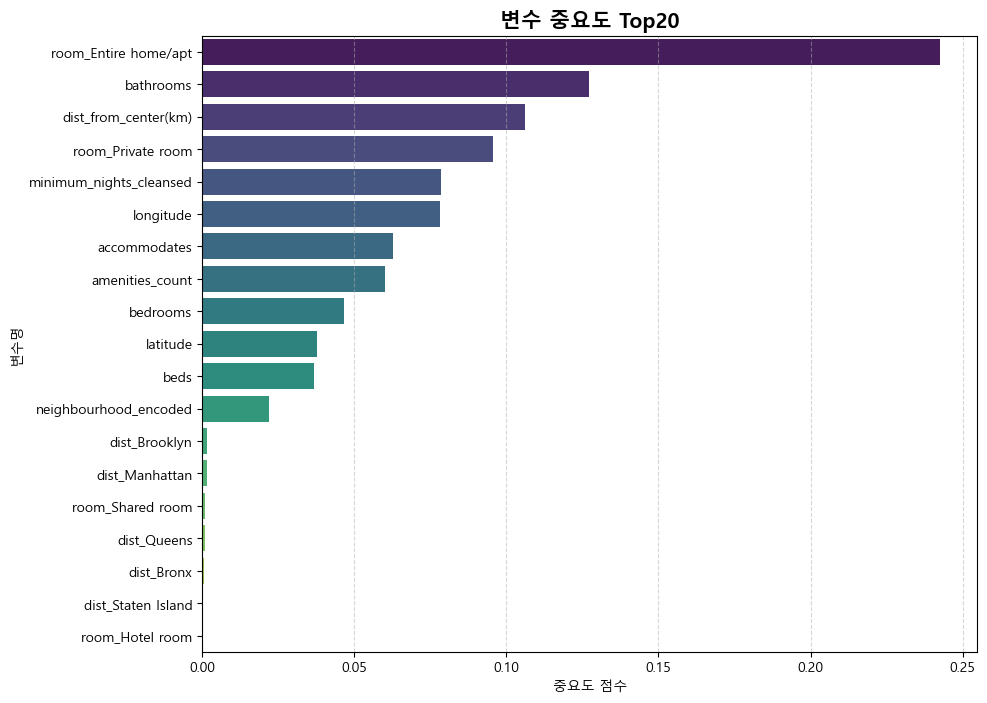

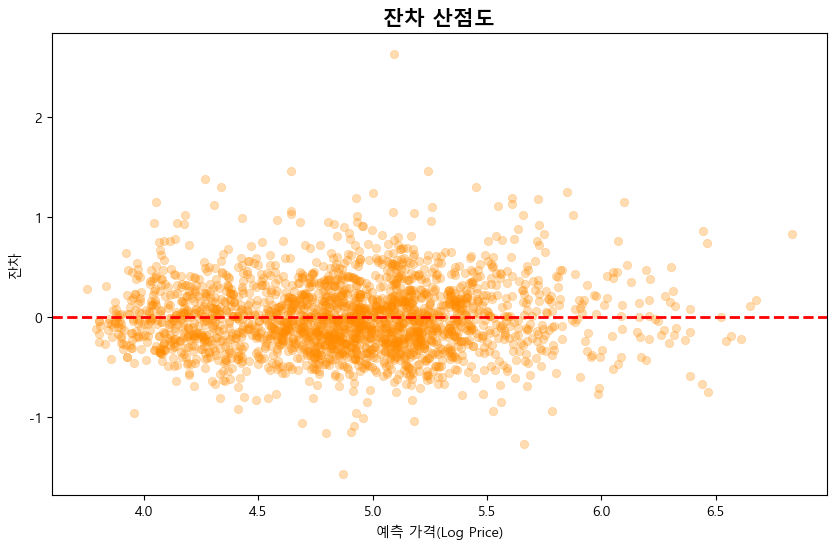

평균 오차율 : 28.18%


In [87]:
# Random Forest 평가

## 과적합
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")
print(f"Gap : {r2_train - r2_test:.4f}")

## 변수 중요도
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top20 = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
sns.barplot(x=top20.values, y=top20.index, palette='viridis')
plt.title('변수 중요도 Top20', fontsize=15, fontweight='bold')
plt.xlabel('중요도 점수')
plt.ylabel('변수명')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## 잔차
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log, y=residuals, alpha=0.3, color='darkorange', edgecolor=None)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('잔차 산점도', fontsize=15, fontweight='bold')
plt.xlabel('예측 가격(Log Price)')
plt.ylabel('잔차')
plt.show()

## 실제 가격 오차율
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
print(f"평균 오차율 : {mape:.2%}")

# XGBoost

In [88]:
import xgboost as xgb
from xgboost import XGBRegressor

X = df_modeling_en_final.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_en_final['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgb_model = XGBRegressor(n_estimators=1000,    
                         learning_rate=0.05,
                         max_depth=7, 
                         early_stopping_rounds=10,
                         random_state=42,
                         n_jobs=-1)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)],
              verbose=False) 

# 예측 수행
y_pred_log = xgb_model.predict(X_test)

# 기본 성능 지표
r2_xgb = r2_score(y_test, y_pred_log)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score : {r2_xgb:.4f}")
print(f"RMSE : {rmse_xgb:.4f}")

R² Score : 0.7022
RMSE : 0.3487


Train R² : 0.8421
Test R² : 0.7022
Gap : 0.1400


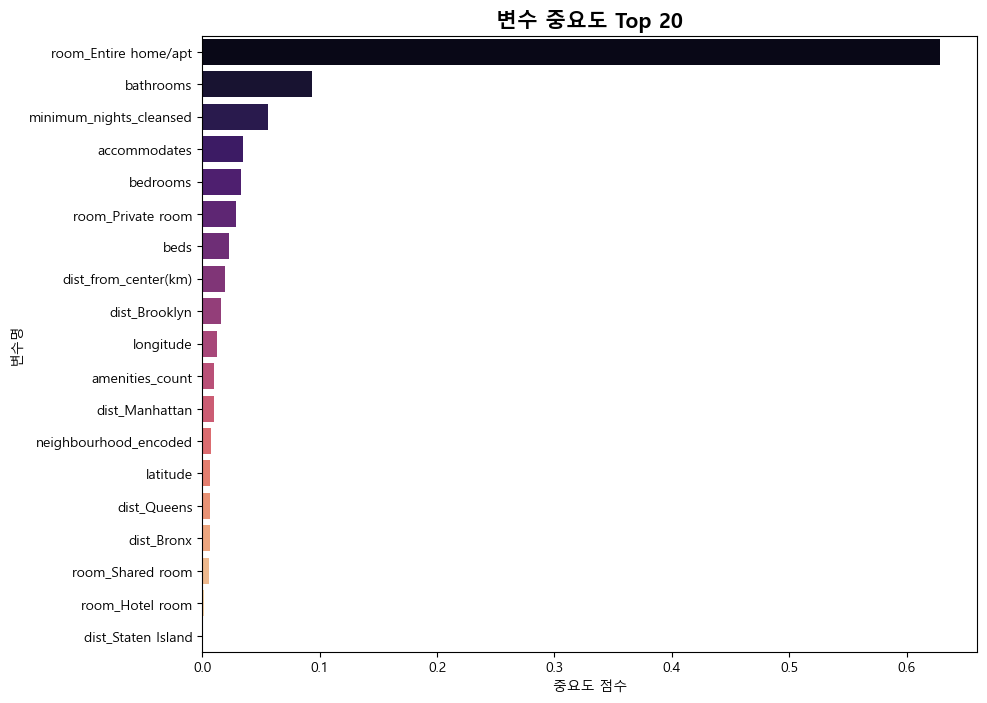

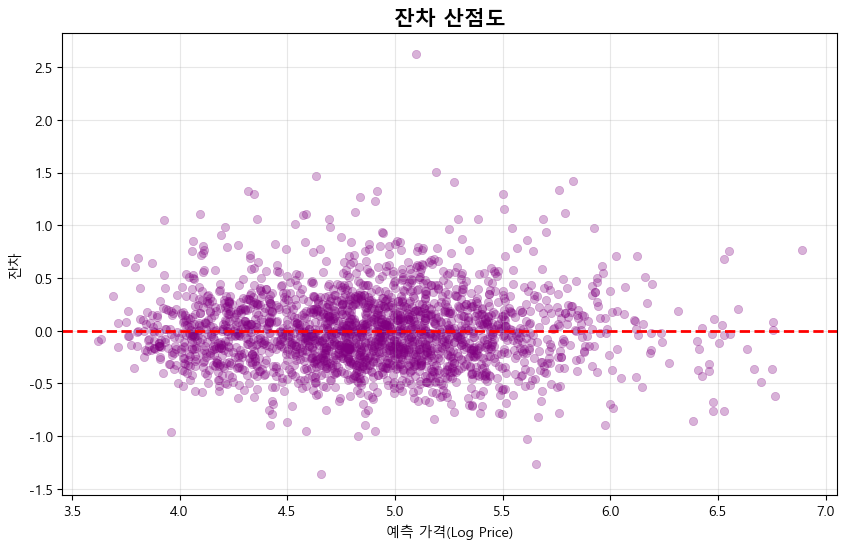

평균 오차율 : 27.25%


In [89]:
# xgboost 모델 평가

## 과적합
# Train 셋 예측 (연습문제 다시 풀어보기)
y_pred_train = xgb_model.predict(X_train)

# Test 셋 예측
y_pred_test = xgb_model.predict(X_test)

# 3. 점수 계산
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# 결과 출력
print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")
print(f"Gap : {r2_train - r2_test:.4f}")

## 변수 중요도
plt.figure(figsize=(10, 8))

importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top20 = importances.sort_values(ascending=False)[:20]

sns.barplot(x=top20.values, y=top20.index, palette='magma')
plt.title('변수 중요도 Top 20', fontsize=15, fontweight='bold')
plt.xlabel('중요도 점수')
plt.ylabel('변수명')
plt.show()

# 잔차
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log, y=residuals, alpha=0.3, color='purple', edgecolor=None)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('잔차 산점도', fontsize=15, fontweight='bold')
plt.xlabel('예측 가격(Log Price)')
plt.ylabel('잔차')
plt.grid(True, alpha=0.3)
plt.show()

# 실제 가격 오차율
y_pred_log = xgb_model.predict(X_test)
y_test_real = np.expm1(y_test)  
y_pred_real = np.expm1(y_pred_log)  
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
print(f"평균 오차율 : {mape:.2%}")

# CatBoost

In [90]:
# 로그 변환
df_modeling_cat = df_modeling.drop('estimated_occupancy', axis=1).copy()

df_modeling_cat['log_price'] = np.log1p(df_modeling_cat['price($)'])

In [91]:
# CatBoost 모델링

from catboost import CatBoostRegressor, Pool

X = df_modeling_cat.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_cat['log_price']

# 범주형 변수 자동 감지
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
cb_model = CatBoostRegressor(n_estimators=1000,
                             learning_rate=0.05,
                             depth=7,
                             cat_features=cat_features,
                             random_state=42)

cb_model.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             early_stopping_rounds=20,
             verbose=100)

# 예측 및 평가
y_pred_log = cb_model.predict(X_test)

r2_cb = r2_score(y_test, y_pred_log)
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score : {r2_cb:.4f}")
print(f"RMSE : {rmse_cb:.4f}")

0:	learn: 0.6180547	test: 0.6218483	best: 0.6218483 (0)	total: 21.8ms	remaining: 21.8s
100:	learn: 0.3612059	test: 0.3678876	best: 0.3678876 (100)	total: 2.27s	remaining: 20.2s
200:	learn: 0.3474718	test: 0.3610924	best: 0.3610924 (200)	total: 4.16s	remaining: 16.6s
300:	learn: 0.3373144	test: 0.3578911	best: 0.3578911 (300)	total: 6.06s	remaining: 14.1s
400:	learn: 0.3294660	test: 0.3557132	best: 0.3556702 (394)	total: 8.07s	remaining: 12.1s
500:	learn: 0.3234058	test: 0.3542533	best: 0.3542392 (499)	total: 10.2s	remaining: 10.1s
600:	learn: 0.3169868	test: 0.3530662	best: 0.3530662 (600)	total: 12s	remaining: 8s
700:	learn: 0.3112536	test: 0.3522937	best: 0.3522449 (693)	total: 15.4s	remaining: 6.55s
800:	learn: 0.3056782	test: 0.3515823	best: 0.3515638 (797)	total: 17.8s	remaining: 4.42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3510748952
bestIteration = 845

Shrink model to first 846 iterations.
R² Score : 0.6981
RMSE : 0.3511


Train R² : 0.7567
Test R² : 0.6981
Gap : 0.0586


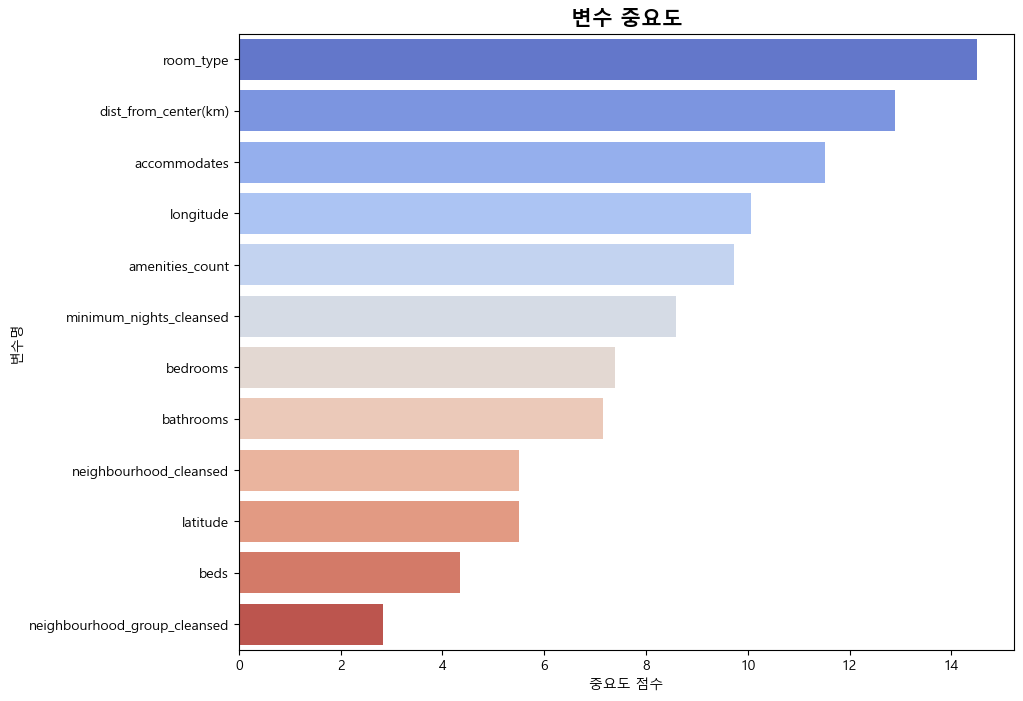

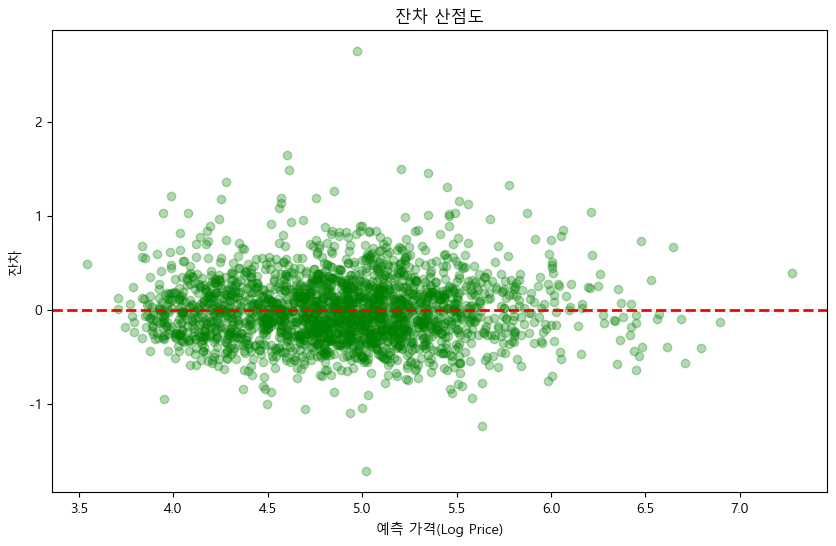

In [92]:
# CatBoost 모델 평가

## 과적합
y_pred_train = cb_model.predict(X_train)
y_pred_test = cb_model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train R² : {r2_train:.4f}")
print(f"Test R² : {r2_test:.4f}")
print(f"Gap : {r2_train - r2_test:.4f}")

## 변수 중요도
importances = pd.Series(cb_model.get_feature_importance(), index=X.columns)
top20 = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
sns.barplot(x=top20.values, y=top20.index, palette='coolwarm')
plt.title('변수 중요도', fontsize=15, fontweight='bold')
plt.xlabel('중요도 점수')
plt.ylabel('변수명')
plt.show()

## 잔차
residuals = y_test - y_pred_log

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_log, residuals, alpha=0.3, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('잔차 산점도')
plt.xlabel('예측 가격(Log Price)')
plt.ylabel('잔차')
plt.show()



In [93]:
# CatBoost 모델링 (Optuna best params 적용)

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = df_modeling_cat.drop(['price($)', 'log_price'], axis=1)
y = df_modeling_cat['log_price']

# 범주형 변수 자동 감지 (컬럼명 리스트)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Optuna best params
best_params = {
    "learning_rate": 0.0417,
    "depth": 9,
    "l2_leaf_reg": 3.4864,
    "bagging_temperature": 0.7645,
    "random_strength": 0.2038,
}

# 모델 생성 및 학습
cb_model = CatBoostRegressor(
    iterations=5000,                 # 넉넉히 주고 early stopping으로 멈추게
    **best_params,
    loss_function="RMSE",
    eval_metric="RMSE",
    cat_features=cat_features,
    random_state=42
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100,        # 20은 짧을 수 있어 100 추천
    verbose=200
)

# 예측 및 평가
y_pred_log = cb_model.predict(X_test)

r2_cb = r2_score(y_test, y_pred_log)
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"R² Score : {r2_cb:.4f}")
print(f"RMSE (log) : {rmse_cb:.4f}")
print("Best iteration:", cb_model.get_best_iteration())


0:	learn: 0.6199528	test: 0.6243040	best: 0.6243040 (0)	total: 29.5ms	remaining: 2m 27s
200:	learn: 0.3335711	test: 0.3598102	best: 0.3598102 (200)	total: 7.11s	remaining: 2m 49s
400:	learn: 0.3122583	test: 0.3540165	best: 0.3540165 (400)	total: 13s	remaining: 2m 29s
600:	learn: 0.2965532	test: 0.3517741	best: 0.3517741 (600)	total: 19.3s	remaining: 2m 21s
800:	learn: 0.2824562	test: 0.3500761	best: 0.3500761 (800)	total: 25.9s	remaining: 2m 15s
1000:	learn: 0.2696256	test: 0.3488179	best: 0.3487871 (998)	total: 32.2s	remaining: 2m 8s
1200:	learn: 0.2570449	test: 0.3480832	best: 0.3480661 (1198)	total: 39.3s	remaining: 2m 4s
1400:	learn: 0.2458925	test: 0.3471906	best: 0.3471634 (1397)	total: 45.6s	remaining: 1m 57s
1600:	learn: 0.2360880	test: 0.3469118	best: 0.3468988 (1582)	total: 51.6s	remaining: 1m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3466240093
bestIteration = 1687

Shrink model to first 1688 iterations.
R² Score : 0.7057
RMSE (log) : 0.3466
Be

In [ ]:
from catboost import Pool

X = df.drop(columns=["price($)"])[:int(len(df)*0.9)]
X_test = df.drop(columns=["price($)"])[int(len(df)*0.9):]
y = np.log1p(df['price($)'])[:int(len(df)*0.9)]
y_test = np.log1p(df['price($)'])[int(len(df)*0.9):]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Identify categorical features
cat_cols = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()

cat_features = [X_train.columns.get_loc(col) for col in cat_cols]

# Create CatBoost Pools
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_features
)

CatBoostError: Invalid type for cat_feature[non-default value idx=11,feature_idx=1]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.